### Tâche 8 : le diagramme de bande

In [5]:
#importation des modules
from pymatgen.ext.matproj import MPRester
from pymatgen.io.cif import CifWriter 
import numpy as np
from pymatgen import Spin
import math

from pymatgen.electronic_structure.bandstructure import BandStructure
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.electronic_structure import plotter

In [6]:
#téléchargement du fichier cif
with MPRester("k7Oj07sVAFLX1l2ahe") as m:
    #attention, on nous demande de télécharger la structure de bande
    struct_band = m.get_bandstructure_by_material_id("mp-15790")

Dans cette section, nous allons déterminer la bande interdite, trouver la direction dans laquelle la dernière (première) bande de valence (conduction) présente le plus et le moins de dispersion et trouver la direction dans laquelle la dernière (première) bande de valence (conduction) présente le plus et le moins de dispersion.

Pour nous aider, nous allons utiliser materials project et les notes de cours du chapitre "Les éléctrons dans le cristal"

Pour commencer, voici le graphique de bande électonique que l'on retrouve sur le site de Material Project 

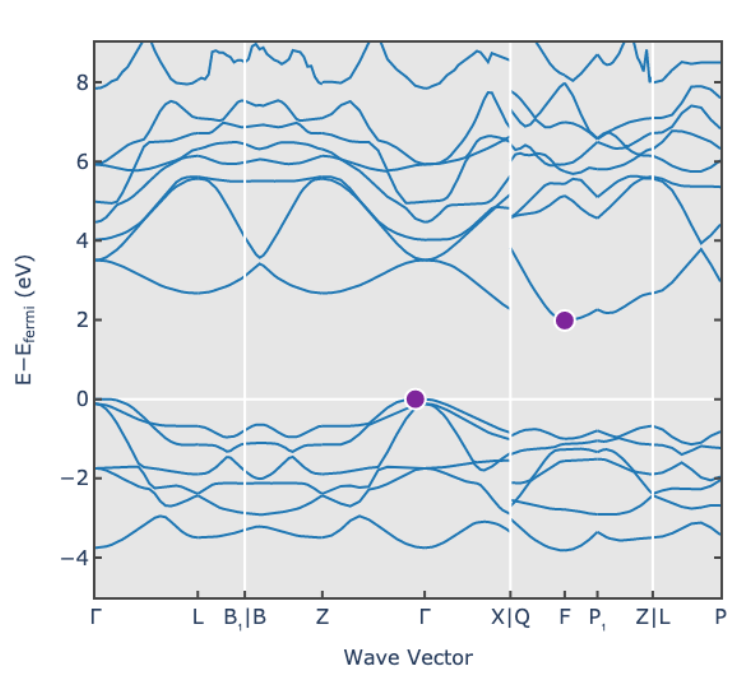

(Les points mauves correspondent au maximum de la bande de valence et le minimum de a bande conduction)



Et celui obtenu grâce à pymatgen:

<module 'matplotlib.pyplot' from '/usr/local/lib64/python3.6/site-packages/matplotlib/pyplot.py'>

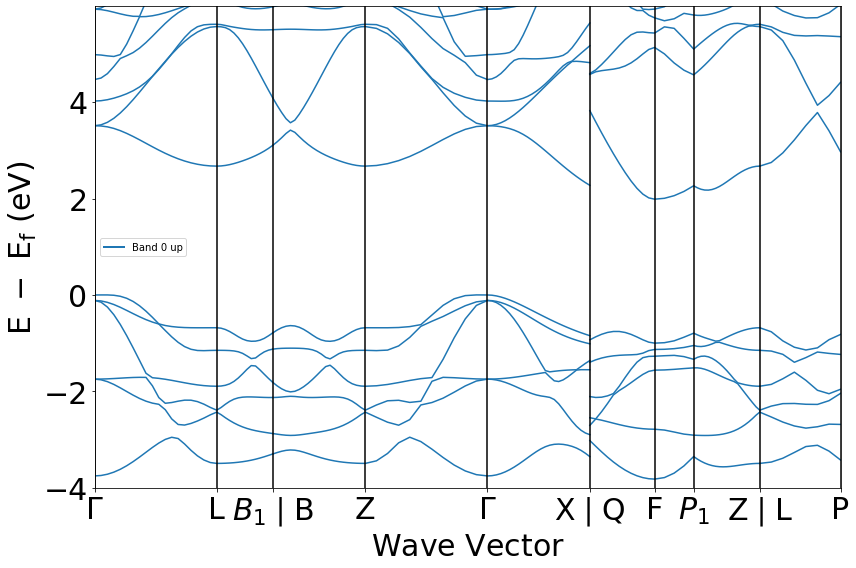

In [7]:
BSPlotter(struct_band).get_plot()

On peut aussi plotter le diagramme des zones de Brillouin afin de mieux visualiser (finalement, le diagramme n'est pas le plus clair)

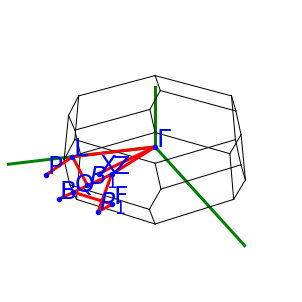

In [8]:
BSPlotter(struct_band).plot_brillouin()

## 1) Détermination de la bande interdite

In [9]:
gap=struct_band.get_direct_band_gap()
print("L'énergie de la bande interdite est de "+ str(gap) + " eV")

L'énergie de la bande interdite est de 2.9868000000000006 eV


Sur Materials project, on trouve que l'énergie de la bande interdite est de 2.135 eV ce qui est inférieur à celle calculée grâce à pymatgen. Materials project stipule en effet que ses valeurs sont sous-estimées du au semi-local DFT donc tout est sous contrôle.

In [10]:
struct_band.get_band_gap()

{'direct': False,
 'energy': 1.9863000000000004,
 'transition': '(0.045,0.045,0.045)-F'}

On peut avoir toutes les informations sur notre bande interdite à savoir qu'elle est indirecte, son énergie (déjà calculée en haut) et sa transition qui n'est donc pas verticale.

## 2) Directions de dispersion 

La dispertion est définie comme E(k), une grande ou une petite direction de dispersion se calculera donc en fonction du taux de variation de l'énergie lorsqu'on varie le vecteur k la direction ne notera d'un point de haute symétrie vers un autre (points critiques) et la dispertion en $\Delta E$.

Pour faire cela, on peut tout simplement le faire visuellement en regardant le diargramme de l'énergie en fonction du vecteur d'onde, il est également possible par après de vérifier ces directions à l'aide de quelques (beaucoup) de lignes de code.

In [11]:
#on cherche le nbre de kpoints par bande 
struct_band.bands[Spin.up].shape #(nbre bande, nbre kpoints)

(20, 136)

### Analyse dernière bande de valence

In [12]:
# Determine le E0
BSP = BSPlotter(struct_band)
data = BSP.bs_plot_data()
Distdata = data.get('ticks').get('distance')
E_0 = data.get('zero_energy')

# Determine la dernière bande de valence
vbm = struct_band.get_vbm()
E_vbm = vbm['energy']
kpoint_vbm = vbm['kpoint'].cart_coords

print('Energie du maximum de la bande de valence = ',E_vbm,'eV')
print('sur le graphe : E-Ef = ', (E_vbm-E_0))
print('Vecteur k (coordonnées cartésiennes) =', kpoint_vbm)
print(vbm.get('band_index'))

Energie du maximum de la bande de valence =  2.6904 eV
sur le graphe : E-Ef =  0.0
Vecteur k (coordonnées cartésiennes) = [ 0.         -0.08475485  0.01540732]
defaultdict(<class 'list'>, {<Spin.up: 1>: [11]})


La dernière bande de valence est la bande 11

### Analyse première bande de conduction

In [13]:
cbm = struct_band.get_cbm()
E_cbm = cbm['energy']
kpoint_cbm = cbm['kpoint'].cart_coords

print('Energie du minimum de la bande de conduction = ',E_cbm,'eV')
print('sur le graphe : E-Ef = ', (E_cbm-E_0))
print('Vecteur k (coordonnées cartésiennes) =',kpoint_cbm)
print(cbm.get('band_index'))

Energie du minimum de la bande de conduction =  4.6767 eV
sur le graphe : E-Ef =  1.9863000000000004
Vecteur k (coordonnées cartésiennes) = [ 0.         -0.93230329 -0.33896055]
defaultdict(<class 'list'>, {<Spin.up: 1>: [12]})


La première bande de conduction est la bande 12

On obtient le graphique suivant

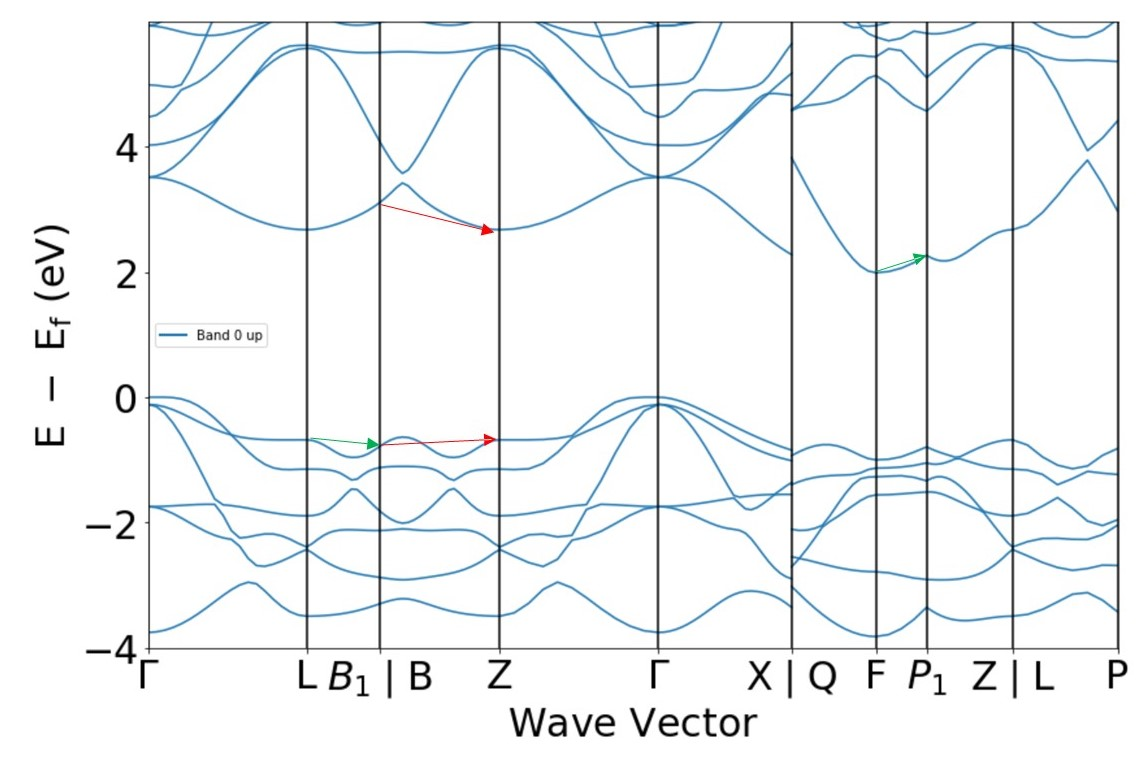

## 3) Masse effective

Pour cette question, nous supposons une dispersion parabolique. Nous utilisons donc comme équation pour l'énergie:$$ E(k)=\frac{\hbar^2 \times k^2}{2\times m_{eff}} $$Ce qui nous permet d'isoler la masse effective.$$ m_{eff}=\frac{\hbar^2 \times k^2}{2\times E(k)} $$Etant donné que le vecteur k est à 3 dimentions:$$ m_{eff}=\frac{\hbar^2 \times (k_x^2+k_y^2+k_z^2)}{2\times E(k)} $$

On applique tout ceci en calcul :

In [54]:
h_bar = 6.5821e-16
m_electron = 9.11e-31
m_vbm = (h_bar**2 * (kpoint_vbm[0]**2+kpoint_vbm[1]**2+kpoint_vbm[2]**2))/(2*abs(E_vbm))
m_cbm = (h_bar**2 * (kpoint_cbm[0]**2+kpoint_cbm[1]**2+kpoint_cbm[2]**2))/(2*E_cbm)
print('La masse effective au sommet de la dernière bande de valence =', m_vbm, 'kg', '=',  m_vbm/m_electron, 'm_e')
print('La masse effective à la base de la première bande de conduction =', m_cbm, 'kg')

La masse effective au sommet de la dernière bande de valence = 5.974906448807277e-34 kg = 0.0006558623983323026 m_e
La masse effective à la base de la première bande de conduction = 4.558180022832528e-32 kg
